In [1]:
import psutil

def get_free_memory():
    memory = psutil.virtual_memory()
    return memory.available / (1024.0 ** 3)  # Convert bytes to gigabytes

print(f"Free CPU Memory: {get_free_memory():.2f} GB")

Free CPU Memory: 663.92 GB


In [2]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
from datasets import Dataset
import os
from deepgo.utils import Ontology


In [6]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = WhitespaceSplit()

In [7]:
tokenizer_path = "WordLevel_tokenizer_trained_InterPro.json"
tokenizer = tokenizer.from_file(tokenizer_path)
tokenizer.enable_truncation(512)

In [8]:
tokenizer.get_vocab_size()


544998

In [9]:
test = tokenizer.encode("WP_265490204 WP_206642677 WP_053312998 WP_251959347 WP_000076573 WP_227526754 WP_218401808 WP_106925592")
test.ids

[1, 2966, 754, 2545, 196, 9231, 2817, 7418, 2526, 2]

In [10]:
import json
with open("/home/toibazd/Most_frequent_IPs.json", "r") as f:
    ips = json.load(f)

sorted_dict = sorted(ips.items(), key=lambda x: x[1], reverse=True)
most_frequent_ips = [item[0] for item in sorted_dict[100:300]]


In [11]:
print(most_frequent_ips[:10])

['IPR017767', 'IPR014395', 'IPR025703', 'IPR004548', 'IPR045062', 'IPR005063', 'IPR003766', 'IPR001656', 'IPR018320', 'IPR047057']


In [12]:
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import csv
from tqdm.auto import tqdm
import numpy as np



ip_to_go = defaultdict(list)
data_dict = defaultdict(list)
enc = MultiLabelBinarizer()
new_tsv_filename = "/home/toibazd/Family_IPs_with_GO.tsv"
go = Ontology('data/go.obo')


with open(new_tsv_filename, "r") as new_tsvfile:
    reader = csv.reader(new_tsvfile, delimiter="\t")
    next(reader)
    for row in tqdm(reader):
        ip = row[0]  # Assuming the IP is in the first column
        go_terms = row[6]  # Assuming the GO terms are in the second column

        # Add IP and corresponding GO terms to data_dict
        ip_to_go[ip]+= go_terms.split(',')


with open("/home/toibazd/Prot2IP_GO_filtered_MF.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])
        

        # Save only if there are filtered InterPro IDs
        for ip in iprs:
            if ip in most_frequent_ips and ip_to_go[ip]:
                for GO in ip_to_go[ip]:
                    data_dict[key].append(GO)
#                     data_dict[key].extend(list(go.get_ancestors(GO)))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [13]:
data_dict

defaultdict(list,
            {'WP_000081439': ['GO:0003700', 'GO:0006355'],
             'WP_002963987': ['GO:0016853', 'GO:0005975'],
             'WP_011161944': ['GO:0008236', 'GO:0006508'],
             'WP_012093980': ['GO:0009002', 'GO:0006508'],
             '4749': ['GO:0005525', 'GO:0015093', 'GO:0006826', 'GO:0016020'],
             'WP_001312828': ['GO:0015562', 'GO:0055085'],
             'WP_000989091': ['GO:0022857', 'GO:0016020'],
             'WP_006115452': ['GO:0015562', 'GO:0055085'],
             'WP_011998903': ['GO:0008168'],
             'WP_011593142': ['GO:0050660', 'GO:0050797', 'GO:0006231'],
             'WP_012143990': ['GO:0016787'],
             'NP_249495': ['GO:0016491'],
             'WP_011391089': ['GO:0016829'],
             'WP_011673674': ['GO:0004637', 'GO:0009113'],
             'WP_225620329': ['GO:0003677', 'GO:0004803', 'GO:0006313'],
             'WP_011916881': ['GO:0008519', 'GO:0072488', 'GO:0016020'],
             'WP_012012557': ['GO:0

In [14]:
len(data_dict)

29057

In [15]:
all_values = [value for values in data_dict.values() for value in values]

# Convert the list into a set to remove duplicates
unique_go = set(all_values)

print("Number of unique words:", len(unique_go))

Number of unique words: 271


In [16]:
print(unique_go)

{'GO:0005315', 'GO:0071705', 'GO:0010181', 'GO:0006821', 'GO:0005840', 'GO:0042919', 'GO:0050660', 'GO:0006817', 'GO:0003935', 'GO:0015079', 'GO:0008410', 'GO:0015703', 'GO:0030955', 'GO:0006007', 'GO:0015093', 'GO:0006520', 'GO:0004654', 'GO:0009082', 'GO:0008234', 'GO:0055085', 'GO:0045239', 'GO:0004743', 'GO:0015078', 'GO:1904680', 'GO:0016793', 'GO:0005524', 'GO:0004784', 'GO:0004055', 'GO:0004176', 'GO:0008697', 'GO:0006974', 'GO:0004619', 'GO:0016310', 'GO:0004540', 'GO:0003824', 'GO:0003989', 'GO:0015562', 'GO:0016868', 'GO:0046917', 'GO:0004803', 'GO:0050151', 'GO:0006631', 'GO:0008270', 'GO:0019239', 'GO:0003924', 'GO:0004459', 'GO:0004601', 'GO:0016783', 'GO:0019867', 'GO:0034480', 'GO:0016759', 'GO:0006529', 'GO:0009254', 'GO:0043214', 'GO:0004386', 'GO:0004639', 'GO:0006281', 'GO:0030983', 'GO:0035438', 'GO:0006526', 'GO:0016831', 'GO:0009617', 'GO:0006807', 'GO:0006355', 'GO:0008168', 'GO:0005886', 'GO:0019829', 'GO:0071951', 'GO:0042925', 'GO:0030163', 'GO:0004089', 'GO:0

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer()
enc.fit(data_dict.values())
one_hot_encoded = enc.transform(data_dict.values())
one_hot_encoded_dict = {key: value for key, value in zip(data_dict.keys(), one_hot_encoded)}

print(len(one_hot_encoded_dict.keys()))

29057


In [18]:
len(one_hot_encoded_dict)

29057

In [19]:
len(one_hot_encoded)

29057

In [20]:
# Find unique numbers and their counts
unique_numbers, counts = np.unique(one_hot_encoded, return_counts=True)
all_count = 0
# Print the count of each number
for number, count in zip(unique_numbers, counts):
    all_count+=count
    print(f"Number {number}: Count {count}")
print(all_count)

Number 0: Count 7807327
Number 1: Count 67120
7874447


In [21]:
# import os
# import random
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor

# directory = '/ibex/user/toibazd/InterPro_annotated_genomes/'
# one_hot_encoded_sentences = {}

# sentence_length = 40
# sentences_per_IP = 200

# # Set random seed for reproducibility
# random.seed(42)

# # Randomly choose 1000 files with seed 42
# selected_files = os.listdir(directory)


# # Define a function to process a file
# def process_file(filename, IP):
#     sentences = []

#     filepath = os.path.join(directory, filename)

#     with open(filepath, 'r') as file:
#         content = file.read()
#         words = content.strip().split()

#         # Check if the key is in the file
#         for i in range(19, len(words)-20):
#             # Shuffle the indices of the words containing the key
#             if IP in data_dict[words[i]]:
#                 if len(words) - i >= 21:
#                     sentence = " ".join(words[i - 19:i + sentence_length - 19])
#                     sentences.append(sentence)
#     return sentences


# # Iterate over keys
# for IP in tqdm(unique_go):
#     one_hot_encoded_sentences[IP] = []
#     sentences_count = 0

#     # Use ThreadPoolExecutor for concurrent processing
#     with ThreadPoolExecutor(max_workers=4) as executor:
#         futures = [executor.submit(process_file, filename, IP) for filename in selected_files]
#         for future in futures:
#             sentences = future.result()
#             one_hot_encoded_sentences[IP].extend(sentences)
#             sentences_count += len(sentences)
#             if sentences_count >= sentences_per_IP:
#                 break

#     # Break if the required number of sentences per key is reached


In [22]:
# import json

# with open('BERT_DNN_senteces_with_GO.json', 'w') as f:
#     json.dump(one_hot_encoded_sentences, f)

In [23]:
import json
with open('BERT_DNN_senteces_with_GO.json', "r") as f:
    one_hot_encoded_sentences = json.load(f)

In [24]:
one_hot_encoded_sentences = {key: value for key, value in one_hot_encoded_sentences.items() if value}
len(one_hot_encoded_sentences)

271

In [25]:
matching_string = one_hot_encoded_sentences.values()
len(matching_string)

271

In [26]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

54598

In [27]:
from transformers import BertModel

# Check if CUDA is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final"

model = BertModel.from_pretrained(model_path).cuda()
model.pooler = None
model.eval()

[2024-03-10 17:10:44,951] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of BertModel were not initialized from the model checkpoint at /home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(544998, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [28]:
print(len(one_hot_encoded[1]))

271


In [29]:
batch_size = 128 # Define your batch size

embeddings = []
labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)

    # Convert lists to tensors and move to device
    input_ids = torch.tensor(input_ids_list).cuda()
    attention_mask = torch.tensor(attention_mask_list).cuda()

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 20, :]
#     relevant_hidden_states = torch.mean(hidden_states[:, 1:-1, :], dim=1)

    
    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        labels.append(one_hot_encoded_dict[indicator])

# Ensure order in embeddings matches order in labels

# Now embeddings and labels are stored on the CPU


  0%|          | 0/427 [00:00<?, ?it/s]

In [30]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [len(embeddings)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(labels).sum(axis=0)
print(class_counts)
pos_weights = calculate_pos_weights(class_counts) 

[ 501  404  404 1465 1001  443  911  401 1266 2354  775 1261 2160  200
  655  457  630  409  627  249  489  519  304  519  443  404  420  427
  512  312  600  513  563  802  602  291  322  404  406  400  424  702
 1761  501  453  241  330  400  408  400  438  627  774  481 1210  983
  482  430  503  697  618  430  662  438  811 5729 1131 2780  655  517
  809  400  538  618  436  635  635 1056  400  600  602  400  443  512
  455  461  489  553 1013  435  637 1210 1240  404  400  438  655  457
  371  983  482  430  503  697 1128  230  420  427  803  602  728  481
  601  695  671  438  662  706  451 1164  438  435  404  400  248  622
  282  831  374  418  371  455  417  365  553 1116  499  630  200  436
  219  409  403  289  398  227  601  513  408 1294  409  630  618  642
  430  625  519  403  911  618  292  627  420  600  709  331  375  436
  308  642  371  401  467  612  407  436  407  460  600 9226  453  601
  754  845 1227  626  284  310  702  538  618  568  553  200  276  208
  200 

In [31]:
pos_weights

tensor([107., 134., 134.,  36.,  53., 122.,  58., 135.,  42.,  22.,  69.,  42.,
         24., 271.,  82., 118.,  85., 132.,  86., 218., 110., 104., 178., 104.,
        122., 134., 128., 126., 105., 173.,  89., 105.,  95.,  67.,  89., 186.,
        168., 134., 133., 135., 127.,  76.,  30., 107., 119., 225., 164., 135.,
        132., 135., 123.,  86.,  69., 112.,  44.,  54., 112., 125., 107.,  77.,
         87., 125.,  81., 123.,  66.,   8.,  47.,  18.,  82., 104.,  66., 135.,
        100.,  87., 124.,  84.,  84.,  50., 135.,  89.,  89., 135., 122., 105.,
        118., 117., 110.,  97.,  52., 124.,  84.,  44.,  43., 134., 135., 123.,
         82., 118., 146.,  54., 112., 125., 107.,  77.,  47., 236., 128., 126.,
         66.,  89.,  73., 112.,  89.,  77.,  80., 123.,  81.,  76., 120.,  45.,
        123., 124., 134., 135., 219.,  86., 192.,  64., 144., 129., 146., 118.,
        129., 148.,  97.,  47., 108.,  85., 271., 124., 248., 132., 134., 187.,
        136., 239.,  89., 105., 132.,  4

In [32]:
len(embeddings)

54598

In [33]:
labels[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [34]:
arrays_list = list(labels)

# Sum over the arrays using numpy's sum function
sum_over_n = np.sum(arrays_list, axis=0)

In [35]:
sum_over_n

array([ 501,  404,  404, 1465, 1001,  443,  911,  401, 1266, 2354,  775,
       1261, 2160,  200,  655,  457,  630,  409,  627,  249,  489,  519,
        304,  519,  443,  404,  420,  427,  512,  312,  600,  513,  563,
        802,  602,  291,  322,  404,  406,  400,  424,  702, 1761,  501,
        453,  241,  330,  400,  408,  400,  438,  627,  774,  481, 1210,
        983,  482,  430,  503,  697,  618,  430,  662,  438,  811, 5729,
       1131, 2780,  655,  517,  809,  400,  538,  618,  436,  635,  635,
       1056,  400,  600,  602,  400,  443,  512,  455,  461,  489,  553,
       1013,  435,  637, 1210, 1240,  404,  400,  438,  655,  457,  371,
        983,  482,  430,  503,  697, 1128,  230,  420,  427,  803,  602,
        728,  481,  601,  695,  671,  438,  662,  706,  451, 1164,  438,
        435,  404,  400,  248,  622,  282,  831,  374,  418,  371,  455,
        417,  365,  553, 1116,  499,  630,  200,  436,  219,  409,  403,
        289,  398,  227,  601,  513,  408, 1294,  4

In [36]:
import random


# Zip the lists together
combined = list(zip(embeddings, labels))

# Shuffle the combined list
random.shuffle(combined)

# Unzip the shuffled list
embeddings, labels = zip(*combined)



In [37]:
model.to("cpu")
torch.cuda.empty_cache()

In [38]:
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 256
first_hidden = 128
second_hidden = 64
last_hidden = 32
output_dim = 271
dropout_prob = 0.25

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [39]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 128
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels

# Define optimizer and loss function
optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.05)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [40]:
import numpy as np

num_epochs = 20
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(embeddings, labels, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        # Convert data to tensors

        batch_embeddings_tensor = torch.stack(batch_embeddings)
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        batch_labels_tensor = batch_labels_tensor.squeeze()

        
        outputs = clf_model(batch_embeddings_tensor)

        
        loss = criterion(outputs, batch_labels_tensor)

        
        train_loss+=loss.item()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")


Epoch 1/20:


Training Batches: 0it [00:00, ?it/s]

0.9890850006632282
Epoch 2/20:


Training Batches: 0it [00:00, ?it/s]

0.8034120650032753
Epoch 3/20:


Training Batches: 0it [00:00, ?it/s]

0.7523725776472538
Epoch 4/20:


Training Batches: 0it [00:00, ?it/s]

0.719976185730488
Epoch 5/20:


Training Batches: 0it [00:00, ?it/s]

0.6952977328078818
Epoch 6/20:


Training Batches: 0it [00:00, ?it/s]

0.653958575743634
Epoch 7/20:


Training Batches: 0it [00:00, ?it/s]

0.6263894260294285
Epoch 8/20:


Training Batches: 0it [00:00, ?it/s]

0.6122458970189955
Epoch 9/20:


Training Batches: 0it [00:00, ?it/s]

0.6025928132739005
Epoch 10/20:


Training Batches: 0it [00:00, ?it/s]

0.5930683693259954
Epoch 11/20:


Training Batches: 0it [00:00, ?it/s]

0.5876538141720757
Epoch 12/20:


Training Batches: 0it [00:00, ?it/s]

0.5870154816884515
Epoch 13/20:


Training Batches: 0it [00:00, ?it/s]

0.5888296922635995
Epoch 14/20:


Training Batches: 0it [00:00, ?it/s]

0.5855122513157783
Epoch 15/20:


Training Batches: 0it [00:00, ?it/s]

0.584902764729141
Epoch 16/20:


Training Batches: 0it [00:00, ?it/s]

0.5833938548606745
Epoch 17/20:


Training Batches: 0it [00:00, ?it/s]

0.5850047130340875
Epoch 18/20:


Training Batches: 0it [00:00, ?it/s]

0.5861358827730471
Epoch 19/20:


Training Batches: 0it [00:00, ?it/s]

0.5857096697595155
Epoch 20/20:


Training Batches: 0it [00:00, ?it/s]

0.5853670136239215
Training finished.


In [41]:
# directory = '/ibex/user/toibazd/InterPro_annotated_genomes_for_testing/'
# one_hot_encoded_sentences_2 = {}

# sentence_length = 40
# sentence_per_IP = 50
# selected_files = os.listdir(directory)


# # Iterate over keys
# for IP in tqdm(unique_go):
#     one_hot_encoded_sentences_2[IP] = []
#     sentences_count=0
    
#     # Iterate over selected files
#     for filename in selected_files:
#         filepath = os.path.join(directory, filename)

#         with open(filepath, 'r') as file:
#             content = file.read()
#             words = content.strip().split()

#             # Check if the key is in the file
#             for i in range(19, len(words)-20):
#                 # Shuffle the indices of the words containing the key
#                 if IP in data_dict[words[i]]:
#                     if len(words) - i >= 21:
#                         sentence = " ".join(words[i - 19:i + sentence_length - 19])
#                         one_hot_encoded_sentences_2[IP].append(sentence)
#                         sentences_count += 1
#                         if sentences_count>=sentence_per_IP:
#                             break
#         if sentences_count>=sentence_per_IP:
#             break
#     print(sentences_count)
            

In [42]:
# import json

# with open('BERT_DNN_senteces_with_GO_test.json', 'w') as f:
#     json.dump(one_hot_encoded_sentences_2, f)

In [43]:
with open('BERT_DNN_senteces_with_GO_test.json', "r") as f:
    test_sentences = json.load(f)

In [44]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
len(test_sentences)

271

In [45]:
matching_string = test_sentences.values()
len(matching_string)

271

In [46]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

13550

In [47]:
batch_size = 128 # Define your batch size
# model.cuda()
test_embeddings = []
test_labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)
    # Convert lists to tensors and move to device
    try:
        input_ids = torch.tensor(input_ids_list)
    except:
        for ins in input_ids_list:
            if len(ins)!=42:
                print(len(ins))
                print(ins)
    attention_mask = torch.tensor(attention_mask_list)

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 20, :]
#     relevant_hidden_states = torch.mean(hidden_states[:, 1:-1, :], dim=1)
    
    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        test_embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        test_labels.append(one_hot_encoded_dict[indicator])


  0%|          | 0/106 [00:00<?, ?it/s]

In [48]:
model.to("cpu")
torch.cuda.empty_cache()

In [49]:
clf_model.eval()

Classification_V0(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=271, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [50]:
generator = data_generator(test_embeddings, test_labels, batch_size)
# Iterate over batches
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
all_predictions = []
all_labels = []
all_probs = []
# Initialize lists to store predictions and labels across all batches
# Iterate over batches
count = 0
for batch_embeddings, batch_labels in tqdm(generator, desc="Evaluation Batches", leave=False):
    batch_embeddings_tensor = torch.stack(batch_embeddings)
    batch_labels = np.array(batch_labels)
    
    logits = clf_model(batch_embeddings_tensor)
    predictions = torch.sigmoid(logits)
    thresholded_predictions = (predictions > 0.85).float()
    all_predictions.append(thresholded_predictions.detach().numpy())
    all_labels.append(batch_labels)
    all_probs.append(predictions.detach().numpy())


Evaluation Batches: 0it [00:00, ?it/s]

In [51]:
len(all_predictions)

106

In [52]:
len(all_labels[0])
    

128

In [53]:
print(all_predictions[0].shape)

(128, 271)


In [54]:

# Concatenate predictions and labels across all batches
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

In [63]:
from sklearn import metrics
auc_scores = []

for i in range(all_labels.shape[1]):  # Iterate over each column
    y = all_labels[:, i]
    pred_y = all_probs[:, i]

    fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
    auc_score = metrics.auc(fpr, tpr)
    auc_scores.append(auc_score)

print("AUC for each column:")
for idx, score in enumerate(auc_scores):
    print(idx,": ", score)

AUC for each column:
0 :  0.9722802121331985
1 :  0.8900832713754647
2 :  0.917314498141264
3 :  0.9709011337158892
4 :  0.9665477084898572
5 :  0.929316157028737
6 :  0.9167201764788127
7 :  0.8886278456738825
8 :  0.9276731738631949
9 :  0.8723915984901556
10 :  0.8785780607827802
11 :  0.8706814392899882
12 :  0.8598389824539155
13 :  0.9120785185185184
14 :  0.9486827959640594
15 :  0.9899814242399256
16 :  0.9359495239694089
17 :  0.81864683058364
18 :  0.976799669673124
19 :  0.8661629931504229
20 :  0.889225290294809
21 :  0.9390669851710907
22 :  0.92664907603932
23 :  0.9540118858471723
24 :  0.9470616883116882
25 :  0.9172802973977695
26 :  0.9830632736545715
27 :  0.9968199006853626
28 :  0.9634227536353456
29 :  0.8849341844813935
30 :  0.9686388059701492
31 :  0.9944272405865828
32 :  0.9195626953401329
33 :  0.9119228647967224
34 :  0.9834198564599137
35 :  0.9530361722305175
36 :  0.8963813348124653
37 :  0.8901204460966543
38 :  0.9753477216042528
39 :  0.98074498141263

In [59]:
all_labels.shape

(13550, 271)

In [4]:
from sklearn import metrics

y = all_labels.flatten()
pred_y = all_probs.flatten()

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
print(metrics.auc(fpr, tpr))

NameError: name 'all_labels' is not defined

In [3]:
fpr

NameError: name 'fpr' is not defined

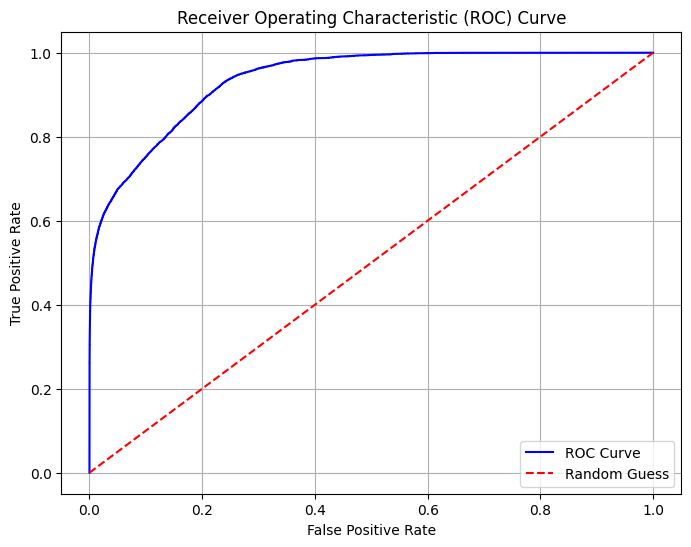

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [141]:
cl_report = multilabel_confusion_matrix(all_labels, all_predictions)
print("Classification report:")
print(len(cl_report))

Classification report:
271


In [142]:
cl_report[0]

array([[13312,   116],
       [   21,   101]])

In [143]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, zero_division=np.nan)

In [144]:
all_predictions.sum(axis=0)

array([217., 196., 174., 396., 304., 158., 330., 136., 186., 251., 130.,
       136., 371., 211., 249., 108., 242.,  71., 170.,  82., 125., 178.,
       143., 200., 168., 176., 200., 136., 213., 142., 218., 144., 182.,
       205., 353.,  78.,  71., 191., 204.,  96., 195., 365., 342., 218.,
       228., 176.,  92., 120., 112., 200., 133., 169., 280., 241., 198.,
       298., 246., 201., 333., 265., 177., 134., 229., 217., 255.,  31.,
       235., 557., 240., 131., 133., 121., 216., 209., 106., 226., 225.,
       371.,  96., 212., 352., 203., 166., 219., 173.,  42., 140.,  43.,
       268., 223., 150., 200., 149., 131., 168., 131., 239., 111., 152.,
       298., 217., 199., 322., 262., 159., 292., 200., 139., 211., 218.,
       220., 240., 150.,  12., 248., 228., 229., 214., 271., 260.,  83.,
       216., 126., 206., 102., 220.,  78., 179.,   6., 409., 173., 132.,
       296., 221., 106., 204., 155., 173., 172., 106., 104., 197., 161.,
        68., 224.,  64., 150., 141., 116., 198., 12

In [145]:
print(report)

              precision    recall  f1-score   support

           0       0.47      0.83      0.60       122
           1       0.22      0.44      0.30       100
           2       0.34      0.60      0.44       100
           3       0.72      0.78      0.75       367
           4       0.63      0.80      0.71       240
           5       0.47      0.70      0.56       106
           6       0.42      0.60      0.49       232
           7       0.22      0.29      0.25       103
           8       0.82      0.60      0.69       254
           9       0.76      0.35      0.48       538
          10       0.36      0.25      0.30       186
          11       0.98      0.41      0.58       324
          12       0.56      0.38      0.46       547
          13       0.11      0.46      0.18        50
          14       0.55      0.86      0.67       159
          15       0.86      0.84      0.85       111
          16       0.45      0.69      0.55       157
          17       0.28    

In [119]:
enc.classes_[1]

'GO:0000105'